# Initialisation

Importing all the relevent libraries and packages

In [1]:
#Import drive
from google.colab import drive
#Mount Google Drive
drive.mount("/content/drive")
%cd "/content/drive/MyDrive/Colaboratory/Fake News/"
import pandas as pd
import numpy as np
import sys
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import one_hot
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
import itertools
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy
nlp = spacy.load("en_core_web_sm")
from sklearn.metrics import confusion_matrix
import seaborn as sb
from matplotlib import pyplot as plt
import string
import os
import re
!pip install json_tricks
from json_tricks import dump, load
!pip install scattertext
import scattertext
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


rs = 87
%matplotlib inline
%pylab inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colaboratory/Fake News
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


#API

Any helper functions creater for the notebook

In [2]:
def text_clean(sentence):

    """
    Function to clean text by removing punctuation and stopwords 
    as well as lemmatizing words
    """
    doc = nlp(sentence)
    tokens = []
    punct = string.punctuation
    sw = list(stopwords.words('english'))

    # lemmatization
    for token in doc:
      
        if token.lemma_ !="-PRON-":
            temp = token.lemma_.lower().strip()
        else:
            temp = token.lower_
        tokens.append(temp)
    # Clean stopwords
    cleaned_tokens = []
    for token in tokens:
        if token not in sw and token not in punct: 
            cleaned_tokens.append(token)
    return cleaned_tokens

def print_reports(actual, predicted, title):
  """
  Function to create a graphic confusion matrix and accuracy report
  """

  actual = actual.map({0:'Truthful', 1:'Fake'})
  predicted = pd.Series(predicted)
  predicted = predicted.map({0:'Truthful', 1:'Fake'}) 

  classes = actual.unique()
  classes.tolist()
  classes.sort()
  cm = confusion_matrix(actual, predicted)
  cm_n = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cm_df = pd.DataFrame(cm_n, index=classes, columns=classes)
  fig = plt.figure(figsize=(9,8))
  try:
        heatmap = sb.heatmap(cm_df, annot=True)
  except ValueError:
        raise ValueError('Confusion matrix values must be ints')

  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
  plt.title(f"{title}")
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show()

  report = classification_report(actual, predicted, target_names=classes, output_dict=True, digits=3)
  report_df = pd.DataFrame(report).transpose()
  # report_df.to_csv(f"{save_report} Speaker Dependence Accuracy.csv")
  print(report_df)


# Load Data

The dataset used is from the Kaggle dataset: https://www.kaggle.com/c/fake-news/data



In [3]:
data = pd.read_csv('/content/drive/MyDrive/Colaboratory/Fake News/DATA/fake-news/train.csv', index_col='id')
train_data = pd.concat([data["text"],data["label"]], axis = 1)


In [4]:
train_data.shape

(20800, 2)

## Remove NANs

Removing any sample that contains NAN values 

In [5]:
train_data.dropna(axis=0, how="any", thresh=None, subset=['text'], inplace=True)


In [6]:
train_data.head()

,text,label
id,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \nAn Iranian woman has been sentenced to...,1


## Data Exploration

Character Length of articles

In [7]:
length = []
[length.append(len(str(text))) for text in train_data['text']]
train_data['length'] = length
print(f"Min Length: {min(train_data['length'])} \nMax Length: {max(train_data['length'])} \nAverage Length: {np.mean(train_data['length'])} \nSTD DEV: {np.std(train_data['length'], axis=0)} ")


Min Length: 1 
Max Length: 142961 
Average Length: 4552.715379798661 
STD DEV: 5130.439927029834 


Word lenght

In [8]:

train_data['totalwords'] = train_data['text'].str.split().str.len()

print(f"\nMin words: {min(train_data['totalwords'])} \nMax words: {max(train_data['totalwords'])} \nAverage words: {(round(sum(train_data['totalwords'])/len(train_data['totalwords'])))} \nSTD DEV: {np.std(train_data['totalwords'], axis=0)}")



Min words: 0 
Max words: 24234 
Average words: 760 
STD DEV: 869.5050460966675


Removing articles with less than n words

In [9]:
min_words = 20
train_data = train_data.drop(train_data['text'][train_data['totalwords'] < min_words].index, axis = 0)
print(f"\nMin words: {min(train_data['totalwords'])} \nMax words: {max(train_data['totalwords'])} \nAverage words: {(round(sum(train_data['totalwords'])/len(train_data['totalwords'])))} \nSTD DEV: {np.std(train_data['totalwords'], axis=0)}")


Min words: 20 
Max words: 24234 
Average words: 777 
STD DEV: 871.7767153415923


Working out sentence frequency by assuming average of 20 words per sentences

In [10]:
print(f"\nMin sen: {round(min(train_data['totalwords'])/20)} \nMax sen: {round(max(train_data['totalwords'])/20)} \nAverage sen: {(round(sum(train_data['totalwords'])/len(train_data['totalwords'])))/20} \nSTD DEV: {round(np.std(train_data['totalwords'], axis=0)/20)}")


Min sen: 1 
Max sen: 1212 
Average sen: 38.85 
STD DEV: 44


In [11]:
labels = train_data.label
labels.value_counts()

0    10385
1     9924
Name: label, dtype: int64

# Prepare Data for Classification

## Split

In [12]:
X_train,X_test,y_train,y_test=train_test_split(train_data['text'], labels, 
                                               train_size=0.8, shuffle=True, 
                                               stratify=labels, random_state=rs)


## TFIDF

In [13]:

tfidf_vectorizer=TfidfVectorizer(tokenizer=text_clean, stop_words='english', max_df=0.7)
#Fit and transform train set, transform test set
X_train=tfidf_vectorizer.fit_transform(X_train).astype('float32')
X_test=tfidf_vectorizer.transform(X_test).astype('float32')
print(X_test.shape)
print(X_train.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  % sorted(inconsistent)


(4062, 155766)
(16247, 155766)


In [14]:
voc_len = len(tfidf_vectorizer.vocabulary_)
voc_len

155766

#Passive Aggressive Classifier 

Accuracy: 97.29
[[2016   61]
 [  49 1936]]


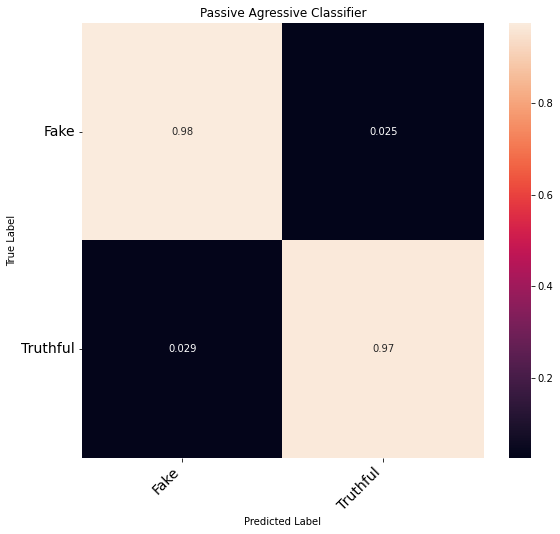

              precision    recall  f1-score     support
Fake           0.969454  0.975315  0.972376  1985.00000
Truthful       0.976271  0.970631  0.973443  2077.00000
accuracy       0.972920  0.972920  0.972920     0.97292
macro avg      0.972863  0.972973  0.972909  4062.00000
weighted avg   0.972940  0.972920  0.972921  4062.00000


In [15]:
pac = PassiveAggressiveClassifier(max_iter=100)
pac.fit(X_train, y_train)
predictions = pac.predict(X_test)
score = accuracy_score(y_test, predictions.ravel())
print(f'Accuracy: {round(score*100,2)}')
print(confusion_matrix(y_test, predictions, labels=[0,1]))

print_reports(y_test, predictions, 'Passive Agressive Classifier')

# Decision Tree Classifier 

Accuracy: 92.74
[[1909  168]
 [ 127 1858]]


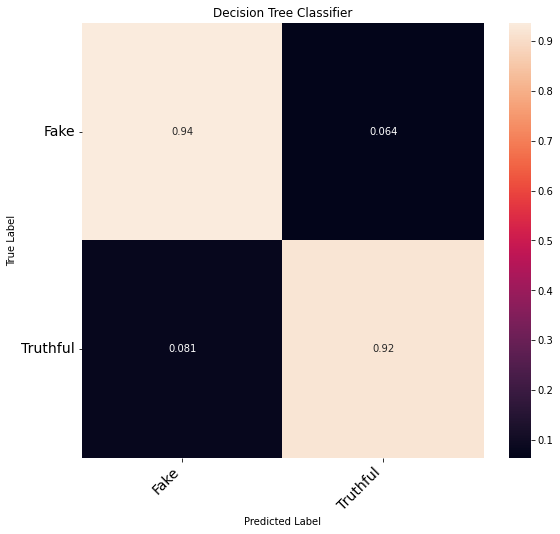

              precision    recall  f1-score      support
Fake           0.917078  0.936020  0.926452  1985.000000
Truthful       0.937623  0.919114  0.928276  2077.000000
accuracy       0.927376  0.927376  0.927376     0.927376
macro avg      0.927350  0.927567  0.927364  4062.000000
weighted avg   0.927583  0.927376  0.927385  4062.000000


In [16]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
predictions = dt.predict(X_test)
score = accuracy_score(y_test, predictions.ravel())
print(f'Accuracy: {round(score*100,2)}')
print(confusion_matrix(y_test, predictions, labels=[0,1]))

print_reports(y_test, predictions, 'Decision Tree Classifier')

# Random Forest Classifier 

Accuracy: 94.39
[[1988   89]
 [ 139 1846]]


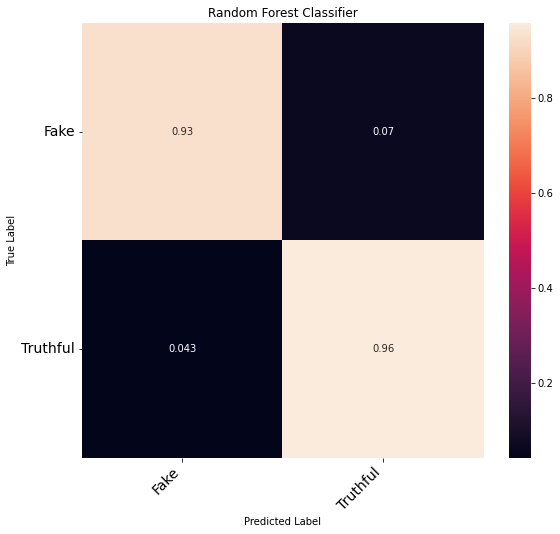

              precision    recall  f1-score     support
Fake           0.954005  0.929975  0.941837  1985.00000
Truthful       0.934650  0.957150  0.945766  2077.00000
accuracy       0.943870  0.943870  0.943870     0.94387
macro avg      0.944327  0.943562  0.943801  4062.00000
weighted avg   0.944108  0.943870  0.943846  4062.00000


In [17]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
score = accuracy_score(y_test, predictions.ravel())
print(f'Accuracy: {round(score*100,2)}')
print(confusion_matrix(y_test, predictions, labels=[0,1]))


print_reports(y_test, predictions, 'Random Forest Classifier')